In [ ]:
#!pip install numpy pandas statsmodels causalgraphicalmodels pyreadr

In [ ]:
import pandas as pd, numpy as np, statsmodels.api as sm, statsmodels.formula.api as smf
import sympy, matplotlib, math, random, networkx
from causalgraphicalmodels import CausalGraphicalModel
from statsmodels.iolib.summary2 import summary_col
import pyreadr
import patsy


# Multicollinearity

## Introduction
**Multicollinearity** occurs when one or more predictor variables in a multiple regression model are highly correlated. This can significantly affect the accuracy of the coefficient estimates within the model.

## Mathematical Explanation

Consider the linear regression model:
$ Y = \beta_0 + \beta_1X_1 + \beta_2X_2 + \ldots + \beta_kX_k + \epsilon $


where:
- $Y$ is the dependent variable
- $X_1, X_2, \ldots, X_k$ are the independent variables
- $\epsilon$ is the error term.

### Normal Equation
The coefficients $\beta$ are estimated using the equation:
$ \beta = (\mathbf{X}´\mathbf{X})^{-1}\mathbf{X}´\mathbf{Y} $

To find $\beta$, the matrix $\mathbf{X}´\mathbf{X}$ must be invertible. However, multicollinearity can make this matrix nearly singular or singular.


### Why $\mathbf{X}´\mathbf{X}$ Becomes Non-invertible
- **Singular Matrix**: If $\mathbf{X}´\mathbf{X}$ is singular, it implies that its determinant is zero due to perfect or high multicollinearity.
- **Linear Dependence**: This happens when one or more independent variables are linear combinations of others.


Matrix Representation

Assume $X_2 = cX_1$, then:
$ \mathbf{X} = \begin{bmatrix} 1 & X_1 & X_2 \\ 1 & X_1 & cX_1 \\ \vdots & \vdots & \vdots \\ 1 & X_1 & cX_1 \end{bmatrix} $


### Covariance Matrix ($\mathbf{X}´\mathbf{X}$)
$ \mathbf{X}´\mathbf{X} = \begin{bmatrix} n & \sum X_1 & c\sum X_1 \\ \sum X_1 & \sum X_1^2 & c\sum X_1^2 \\ c\sum X_1 & c\sum X_1^2 & c^2\sum X_1^2 \end{bmatrix} $


Here, the columns of $\mathbf{X}´\mathbf{X}$ are linear combinations of each other, which results in:
$ \text{det}(\mathbf{X}´\mathbf{X}) = 0 $
indicating that the matrix is not invertible due to multicollinearity.

###Example

**-Economic indicators** Predicting country's economic growth using both consumer spending and consumer income as predictors might lead to multicollinearity because these two are highly correlated; higher income generally leads to higher spending. Including both in the same regression model can cause issues in accurately estimating the impact of each predictor on economic growth.

**-Real Estate Pricing** In real estate, the size of a house and the number of rooms often exhibit multicollinearity. Both these variables tend to increase together; a larger house typically has more rooms. If both variables are used as predictors in a regression model to predict house prices, their high correlation can distort the individual effect of each variable on the pricing, making it difficult to assess which feature (size or number of rooms) truly impacts the house price.






### Testing for invertibility




In [ ]:
# seed for reproducibility
np.random.seed(3)
# 10x10 matrix with 9 columns following a normal distribution
A = np.random.randn(10, 9)
# 10th column as a linear combination of three other columns
A = np.hstack([A, (2 * A[:,0] + 3 * A[:,1] -  A[:,8]).reshape(10, 1)])

# 1st attempt to invert the matrix
try:
    inv_A = np.linalg.inv(A)
    print("Inverse computed successfully:\n",inv_A)
except np.linalg.LinAlgError:
    print("Matrix is singular and cannot be inverted")

Matrix is singular and cannot be inverted


In Colab, unlike jupyter notebook, the matrix is non-invertible. This result reflects what was previously expressed, as we have linearly dependent vectors we cannot estimate $\beta$

In [ ]:
## loading the data
Penn = pd.read_csv("C:/Users/arami/Desktop/penn_jae.dat" , sep='\s', engine='python')
n = Penn.shape[0]
p_1 = Penn.shape[1]
Penn = Penn[ (Penn['tg'] == 2) | (Penn['tg'] == 0) ]

In [ ]:
# Dependent variable
Penn['T2'] = (Penn[['tg']]==2).astype(int)

# Create category variable
Penn['dep'] = Penn['dep'].astype( 'category' )
Penn.head()
Penn['dep'].unique()

[2, 0, 1]
Categories (3, int64): [0, 1, 2]

In [ ]:
# Carry out covariate balance check

formula1 = "T2~(female+black+othrace+C(dep)+q2+q3+q4+q5+q6+agelt35+agegt54+durable+lusd+husd)**2"

model_results = smf.ols(formula1, data = Penn).fit().get_robustcov_results(cov_type = "HC1")

print(model_results.summary())
print( "Number of regressors in the basic model:",len(model_results.params), '\n')

C:\Users\arami\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\arami\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


                            OLS Regression Results                            
Dep. Variable:                     T2   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     4.748
Date:                Tue, 23 Apr 2024   Prob (F-statistic):           5.79e-51
Time:                        21:37:27   Log-Likelihood:                -4065.8
No. Observations:                5782   AIC:                             8352.
Df Residuals:                    5672   BIC:                             9084.
Df Model:                         109                                         
Covariance Type:                  HC1                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.5090    

C:\Users\arami\anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 119, but rank is 108
  warnings.warn('covariance of constraints does not have full '


In [ ]:
# Regress treatment on all covariates using data from R
y = Penn[['T2']].reset_index( drop = True )
# Get data from R
result = pyreadr.read_r('C:/Users/arami/Desktop/m_reg_g2.RData')
X_vars = result['X1']

# model = "T2~(female+black+othrace+C(dep)+q2+q3+q4+q5+q6+agelt35+agegt54+durable+lusd+husd)**2"

model_results = sm.OLS( y, X_vars ).fit().get_robustcov_results(cov_type = "HC1")

print(model_results.summary())
print( "Number of regressors in the basic model:",len(model_results.params), '\n')


                            OLS Regression Results                            
Dep. Variable:                     T2   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                     4.204
Date:                Tue, 23 Apr 2024   Prob (F-statistic):           2.42e-39
Time:                        21:37:27   Log-Likelihood:                -4075.6
No. Observations:                5782   AIC:                             8357.
Df Residuals:                    5679   BIC:                             9043.
Df Model:                         102                                         
Covariance Type:                  HC1                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
(Intercept)              0.5171 

C:\Users\arami\anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 102, but rank is 101
  warnings.warn('covariance of constraints does not have full '


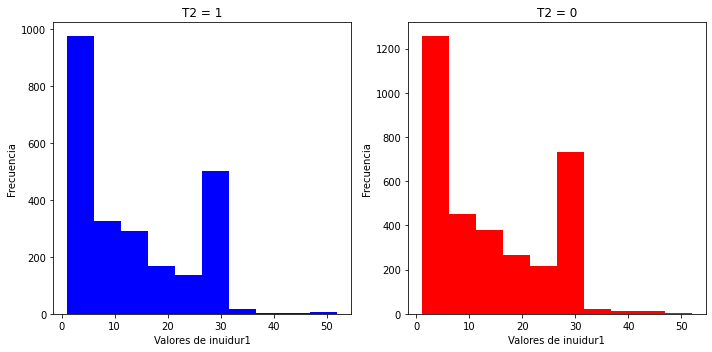

In [ ]:
# Plot two histograms for treatment and control group to see the distribution of the outcome variable inuidur1
import matplotlib.pyplot as plt

inuidur1_t2_1 = Penn[Penn['T2'] == 1]['inuidur1']
inuidur1_t2_0 = Penn[Penn['T2'] == 0]['inuidur1']

# Crear una figura y subtramas
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Crear histograma para T2 = 1
axs[0].hist(inuidur1_t2_1, bins=10, color='blue')
axs[0].set_title('T2 = 1')

# Crear histograma para T2 = 0
axs[1].hist(inuidur1_t2_0, bins=10, color='red')
axs[1].set_title('T2 = 0')

# Agregar etiquetas de ejes
for ax in axs:
    ax.set_xlabel('Valores de inuidur1')
    ax.set_ylabel('Frecuencia')

# Mostrar el histograma
plt.tight_layout()
plt.show()

Run all specifications:
classical 2-sample approach, no adjustment (CL)
classical linear regression adjustment (CRA)
interactive regression adjustment (IRA)
interactive regression adjustment (IRA) using Lasso. Use Hdm package for Python , R and Julia scripts.

In [ ]:
# Model specification
# take log of inuidur1
Penn["log_inuidur1"] = np.log( Penn["inuidur1"] )
log_inuidur1 = pd.DataFrame(np.log( Penn["inuidur1"] ) ).reset_index( drop = True )

# no adjustment (2-sample approach)
formula_cl = 'log_inuidur1 ~ T2'

ols_cl = smf.ols( formula = formula_cl, data = Penn ).fit().get_robustcov_results(cov_type = "HC1")

In [ ]:
# adding controls

formula_cra = 'log_inuidur1 ~ T2 + (female+black+othrace+C(dep)+q2+q3+q4+q5+q6+agelt35+agegt54+durable+lusd+husd)**2'
# Omitted dummies: q1, nondurable, muld

ols_cra = smf.ols( formula = formula_cra, data = Penn ).fit().get_robustcov_results(cov_type = "HC1")


print(ols_cl.summary())
print(ols_cra.summary())
print( "Number of regressors in the control model:",len(ols_cra.params), '\n')

                            OLS Regression Results                            
Dep. Variable:           log_inuidur1   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     5.879
Date:                Tue, 23 Apr 2024   Prob (F-statistic):             0.0154
Time:                        21:37:29   Log-Likelihood:                -9344.7
No. Observations:                5782   AIC:                         1.869e+04
Df Residuals:                    5780   BIC:                         1.871e+04
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.0568      0.021     98.158      0.0

C:\Users\arami\anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 120, but rank is 109
  warnings.warn('covariance of constraints does not have full '


In [ ]:
# Model Specification using data from R
# take log of inuidur1
log_inuidur1 = pd.DataFrame(np.log( Penn["inuidur1"] ) ).reset_index( drop = True )

# no adjustment (2-sample approach)
formula_cl = 'log_inuidur1 ~ T2'

# adding controls
# formula_cra = 'log_inuidur1 ~ T2 + (female+black+othrace+dep+q2+q3+q4+q5+q6+agelt35+agegt54+durable+lusd+husd)**2'
# Omitted dummies: q1, nondurable, muld

ols_cl = smf.ols( formula = formula_cl, data = Penn ).fit().get_robustcov_results(cov_type = "HC1")

In [ ]:
#getting data
# Get data from R
result = pyreadr.read_r('C:/Users/arami/Desktop/ols_cra_reg_g2.RData')
X_vars = result['X1']

ols_cra = sm.OLS( log_inuidur1, X_vars ).fit().get_robustcov_results(cov_type = "HC1")

# Results
print(ols_cl.summary())
print(ols_cra.summary())
print( "Number of regressors in the interactive model:",len(ols_cra.params), '\n')

# create Y variable
log_inuidur1 = pd.DataFrame(np.log( Penn["inuidur1"] )).reset_index( drop = True )

# Reset index to estimation
# Get data from R
result = pyreadr.read_r('C:/Users/arami/Desktop/ols_ira_reg_g2.RData')
X_vars = result['S1']

ols_ira = sm.OLS( log_inuidur1, X_vars ).fit().get_robustcov_results(cov_type = "HC1")

# Results
print(ols_ira.summary())

                            OLS Regression Results                            
Dep. Variable:           log_inuidur1   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     5.879
Date:                Tue, 23 Apr 2024   Prob (F-statistic):             0.0154
Time:                        21:37:29   Log-Likelihood:                -9344.7
No. Observations:                5782   AIC:                         1.869e+04
Df Residuals:                    5780   BIC:                         1.871e+04
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.0568      0.021     98.158      0.0

C:\Users\arami\anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 103, but rank is 102
  warnings.warn('covariance of constraints does not have full '


                            OLS Regression Results                            
Dep. Variable:               inuidur1   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     35.02
Date:                Tue, 23 Apr 2024   Prob (F-statistic):               0.00
Time:                        21:37:30   Log-Likelihood:                -9129.1
No. Observations:                5782   AIC:                         1.866e+04
Df Residuals:                    5579   BIC:                         2.002e+04
Df Model:                         202                                         
Covariance Type:                  HC1                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
(Intercept)     

C:\Users\arami\anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 202, but rank is 188
  warnings.warn('covariance of constraints does not have full '


Using the 3. interactive regression adjustment (IRA) plot the coefficients of the next variables: T2*female, T2*black,T2*agelt35, T2*factor(dep)1


In [ ]:
ols_ira_res = pd.read_html(ols_ira.summary().tables[1].as_html(),header=0,index_col=0)[0]

coef_df = ols_ira_res.loc[['T2TRUE:Xfemale', 'T2TRUE:Xblack', 'T2TRUE:Xagelt35', 'T2TRUE:Xfactor(dep)1'], ['coef', 'std err']]

coef_df['varname'] = ['T2*female', 'T2*black', 'T2*agelt35', 'T2*factor(dep)1']

coef_df

,coef,std err,varname
T2TRUE:Xfemale,-0.6598,0.550,T2*female
T2TRUE:Xblack,0.4526,0.510,T2*black
T2TRUE:Xagelt35,1.1233,0.637,T2*agelt35
T2TRUE:Xfactor(dep)1,0.7636,0.785,T2*factor(dep)1


<ipython-input-13-41a9ec4058d8>:7: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  ax.scatter(x=pd.np.arange(coef_df.shape[0]),


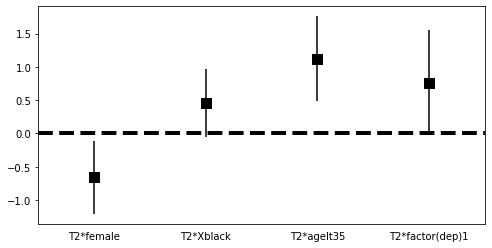

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
coef_df.plot(x='varname', y='coef', kind='bar',
             ax=ax, color='none',
             yerr='std err', legend=False)
ax.set_ylabel('')
ax.set_xlabel('')
ax.scatter(x=pd.np.arange(coef_df.shape[0]),
           marker='s', s=120,
           y=coef_df['coef'], color='black')
ax.axhline(y=0, linestyle='--', color='black', linewidth=4)
ax.xaxis.set_ticks_position('none')
_ = ax.set_xticklabels(['T2*female', 'T2*Xblack', 'T2*agelt35', 'T2*factor(dep)1'],
                       rotation=0, fontsize=10)

Comment this figure and give an explanation for the coefficients.

This graph shows that the effect of receiving monetary compensation and being over 35 years of age affects the time of unemployment by 1.12 units. Likewise, the effect of receiving monetary compensation and being black affects unemployment time by 0.45 units. Furthermore, the effect of receiving monetary compensation and having at least one dependent affects the unemployment time by 0.76 units. Finally, the effect of receiving monetary compensation and being a woman negatively affects unemployment time by 0.66 units. But the coefficients of the interaction with being black and the number of dependents are not significant because the values of the confidence intervals can be zero.

In [ ]:
# Next we try out partialling out with lasso
!pip install multiprocess

In [ ]:
import hdmpy as hdm
# Get data from R
result = pyreadr.read_r('C:/Users/arami/Desktop/rlasso_ira_reg_g2.RData')
X_vars = result['S']

X_vars

result = hdm.rlassoEffects( X_vars, log_inuidur1, index = 0 )

rlasso_ira = pd.DataFrame(np.array( (result.res['coefficients'][0] , result.res['se'][0] , \
           result.res['t'][0] , result.res['pval'][0] ) ).reshape(1, 4) , columns = ['Coef.' , \
                            "Std.Err." , "t" , 'P>|t|'] , index = ['T2'])

# result.res is a object dictionary
result.res.keys()

result.res['coefficients']

rlasso_ira

# Results
table2 = np.zeros((2, 4))
table2[0,0] = ols_cl.summary2().tables[1]['Coef.']['T2']
table2[0,1] = ols_cra.summary2().tables[1]['Coef.']['T2']
table2[0,2] = ols_ira.summary2().tables[1]['Coef.']['T2']
table2[0,3] = rlasso_ira['Coef.']['T2']

table2[1,0] = ols_cl.summary2().tables[1]['Std.Err.']['T2']
table2[1,1] = ols_cra.summary2().tables[1]['Std.Err.']['T2']
table2[1,2] = ols_ira.summary2().tables[1]['Std.Err.']['T2']
table2[1,3] = rlasso_ira['Std.Err.']['T2']

table2 = pd.DataFrame(table2, columns = ["CL", "CRA", "IRA", "IRA Lasso"], \
                      index = ["estimate","standard error"])
table2

table2.to_latex
print(table2.to_latex())


\begin{tabular}{lrrrr}
\toprule
{} &        CL &       CRA &       IRA &  IRA Lasso \\
\midrule
estimate       & -0.078825 & -0.071207 & -0.069904 &  -0.074574 \\
standard error &  0.032509 &  0.032044 &  0.032076 &   0.032104 \\
\bottomrule
\end{tabular}



<ipython-input-16-4997f4719885>:37: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table2.to_latex())


Treatment group 2 experiences an average decrease of about  (7.4574)%  in the length of unemployment spell.

# A Crash Course in Good and Bad Controls

In this section, we will cover various models that illustrate "good" and "bad" controls within statistical analyses. These terms refer to the effects of adding a variable to a regression model—whether such inclusion results in discrepancies or aids interpretation of the model. For a more detailed exploration of these concepts, you are encouraged to review the full text available in the technical report [here](https://ftp.cs.ucla.edu/pub/stat_ser/r493.pdf).



#Good Controls 1 (blocking back-door paths)
###MODEL 1
In this case, we want to measure the effect of hours of study ($X$) on students' academic performance as measured by final grades ($Y$). If we run the regression without taking into account nutrition ($Z$), which affects both $X$ and $Y$, the coefficients will be biased. By including $Z$ in the model, a cleaner effect of hours of study on final grades can be obtained, approaching 1, which is the true parameter ( $1.0088\approx1$).


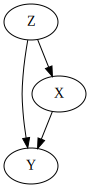

In [ ]:
sprinkler = CausalGraphicalModel(nodes=["Z","Y","X"],
                                 edges=[("Z","Y"),
                                        ("Z","X"),
                                        ("X","Y")])
sprinkler.draw()

In [ ]:
# Set Seed
# to make the results replicable (generating random numbers)
np.random.seed(1234567)     # set MC seed

n = 10000              # sample size
Z = np.random.normal(0,1, 1000).reshape((1000, 1))
X = 2*Z + np.random.normal(0, 1, 1000).reshape((1000, 1))
Y = X + 1*Z + np.random.normal(0, 1, 1000).reshape((1000, 1))

# Create dataframe
D = np.hstack((Z, X, Y))
data = pd.DataFrame(D, columns = ["Z", "X", "Y"])


In [ ]:
# Regressions
no_control = "Y ~ X"          #Wrong, not controlling by nutrition
using_control = "Y ~ X + Z"   # Correct

no_control = smf.ols(no_control , data=data).fit()
using_control = smf.ols(using_control , data=data).fit()

# Summary results
dfoutput = summary_col([no_control,using_control],stars=True)
print(dfoutput)


                  Y I       Y II  
----------------------------------
Intercept      0.0107    -0.0039  
               (0.0351)  (0.0323) 
X              1.3965*** 1.0088***
               (0.0162)  (0.0323) 
Z                        0.9710***
                         (0.0718) 
R-squared      0.8818    0.9001   
R-squared Adj. 0.8816    0.8999   
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


###Model 2
In this case we want to see how much anti-corruption laws($X$) affect the number of corruption cases($Y$). But there is an unobservable variable that affects both, which is the feeling of injustice, which drives criminality and increases the number of laws. Then, we control for the number of active judges($Z$) to clean up the effect of the unobservable on my X. Finally controlling, my coefficient is close to my variable ($0.4321\approx 0.5$).



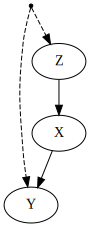

In [ ]:
sprinkler = CausalGraphicalModel(nodes=["Z","Y","X"],
                                 edges=[("Z","X"),
                                        ("X","Y")],
                                 latent_edges=[("Z","Y")])
sprinkler.draw()

In [ ]:
# Set Seed
# to make the results replicable (generating random numbers)
np.random.seed(1234567)     # set MC seed

n = 1000                # sample size
U = np.random.normal(0, 1, 1000).reshape((1000, 1))
Z = 3*U + np.random.normal(0, 1, 1000).reshape((1000, 1)) # generate Z
X = 1*Z + np.random.normal(0, 1, 1000).reshape((1000, 1))
Y = 0.5*X + 2*U + np.random.normal(0, 1, 1000).reshape((1000, 1))

# Create dataframe
D = np.hstack((U, Z, X, Y))
data = pd.DataFrame(D, columns = ["U", "Z", "X", "Y"])

In [ ]:
# Regressions
no_control = "Y ~ X"           #Wrong, not controlling for confounder
using_control = "Y ~ X + Z"      #classical

no_control = smf.ols(no_control , data=data).fit()
using_control = smf.ols(using_control , data=data).fit()

# Summary results
dfoutput = summary_col([no_control,using_control],stars=True)
print(dfoutput)


                  Y I       Y II  
----------------------------------
Intercept      0.0348    0.0253   
               (0.0434)  (0.0383) 
X              1.0341*** 0.4321***
               (0.0134)  (0.0375) 
Z                        0.6671***
                         (0.0394) 
R-squared      0.8556    0.8878   
R-squared Adj. 0.8555    0.8876   
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


#Bad Control (M-bias)
##MODEL 7
Now, if we want to study how education($X$) affects diabetes($Y$) we could adjust for the mother's diabetes status($Z$) and consider it a confounder. However, this association is not direct, and adjusting for the mother will open up an association with income during childhood (U_1) and overall risk of diabetes (U_2).

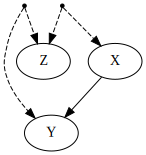

In [ ]:
sprinkler = CausalGraphicalModel(nodes=["Z","Y","X"],
                                 edges=[("X","Y")],
                                 latent_edges=[("X","Z"),("Z","Y")]
                                )
sprinkler.draw()

In [ ]:
# Set Seed
# to make the results replicable (generating random numbers)
np.random.seed(12345676)     # set MC seed

n = 1000                # sample size
U_1 = np.random.normal(0, 1, 1000).reshape((1000, 1))
U_2 = np.random.normal(0, 1, 1000).reshape((1000, 1))

Z = 1*U_1 + 1*U_2 + np.random.normal(0, 1, 1000).reshape((1000, 1)) # generate Z
X = 1.5*U_1 + np.random.normal(0, 1, 1000).reshape((1000, 1))
Y = X + 2.5*U_2 + np.random.normal(0, 1, 1000).reshape((1000, 1))

# Create dataframe
D = np.hstack((U_1,U_2, Z, X, Y))
data = pd.DataFrame(D, columns = ["U_1", "U_2", "Z", "X", "Y"])

In [ ]:
# Regressions
no_control = "Y ~ X"
using_control = "Y ~ X + Z"      #classical

no_control = smf.ols(no_control , data=data).fit()
using_control = smf.ols(using_control , data=data).fit()

# Summary results
dfoutput = summary_col([no_control,using_control],stars=True)
print(dfoutput)


                  Y I       Y II  
----------------------------------
Intercept      0.0219    -0.0210  
               (0.0850)  (0.0668) 
X              1.0433*** 0.5338***
               (0.0469)  (0.0422) 
Z                        1.0602***
                         (0.0426) 
R-squared      0.3316    0.5875   
R-squared Adj. 0.3310    0.5867   
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


#Neutral Control (possibly good for precision)
###Model 8
In this case, we want to estimate how the introduction of a new smart learning programme ($X$) affects the academic performance of students ($Y$). When we run this regression, our estimator is unbiased. However, if we include the attendance rate ($Z$), which also affects performance, we can increase the precision of the estimator and still remain unbiased and increase the precision.

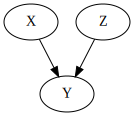

In [ ]:
sprinkler = CausalGraphicalModel(nodes=["Z","Y","X"],
                                 edges=[("Z","Y"),("X","Y")])
sprinkler.draw()

In [ ]:
# Set Seed
# to make the results replicable (generating random numbers)
np.random.seed(12345676)     # set MC seed

n = 1000                # sample size

Z = np.random.normal(0, 1, 1000).reshape((1000, 1))
X = np.random.normal(0, 1, 1000).reshape((1000, 1))
Y = X + 1.5*Z + np.random.normal(0, 1, 1000).reshape((1000, 1))

# Create dataframe
D = np.hstack((Z, X, Y))
data = pd.DataFrame(D, columns = ["Z", "X", "Y"])

In [ ]:
# Regressions
no_control = "Y ~ X"
using_control = "Y ~ X + Z"      #classical

no_control = smf.ols(no_control , data=data).fit()
using_control = smf.ols(using_control , data=data).fit()

# Summary results
dfoutput = summary_col([no_control,using_control],stars=True)
print(dfoutput)


                  Y I       Y II  
----------------------------------
Intercept      0.1056*   0.0001   
               (0.0578)  (0.0327) 
X              1.0865*** 1.0192***
               (0.0578)  (0.0327) 
Z                        1.5158***
                         (0.0329) 
R-squared      0.2616    0.7642   
R-squared Adj. 0.2608    0.7638   
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


#Bad Controls (Overcontrol Bias)
##Model 11
In this case we want to analyse how the growth of the city in terms of urban infrastructure (residential areas, shopping centres, etc.) impacts on the level of vehicle congestion ($Y$). Now, if we add a variable such as the number of cars ($Z$) that is affected by the infrastructure, but not vice versa and that causes a higher level of congestion, we would be removing the explanatory power of $X$. Now by controlling for both variables, the estimator of X loses significance and moves away from its true estimator ($-0.022\neq1$).


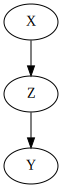

In [ ]:
sprinkler = CausalGraphicalModel(nodes=["Z","Y","X"],
                                 edges=[("X","Z"),("Z","Y")])
sprinkler.draw()

In [ ]:
# Set Seed
# to make the results replicable (generating random numbers)
np.random.seed(1234567)     # set MC seed

n = 1000                # sample size
X = np.random.normal(0, 1, 1000).reshape((1000, 1)) # generate Z
Z = 1.3*X + np.random.normal(0, 1, 1000).reshape((1000, 1))
Y = 1*Z + np.random.normal(0, 1, 1000).reshape((1000, 1))

# Create dataframe
D = np.hstack((Z, X, Y))
data = pd.DataFrame(D, columns = ["Z", "X", "Y"])

In [ ]:
# Regressions
no_control = "Y ~ X"
using_control = "Y ~ X + Z"      #classical

no_control = smf.ols(no_control , data=data).fit()
using_control = smf.ols(using_control , data=data).fit()

# Summary results
dfoutput = summary_col([no_control,using_control],stars=True)
print(dfoutput)


                  Y I       Y II  
----------------------------------
Intercept      -0.0204   -0.0039  
               (0.0455)  (0.0323) 
X              1.2604*** -0.0229  
               (0.0465)  (0.0527) 
Z                        1.0088***
                         (0.0323) 
R-squared      0.4239    0.7089   
R-squared Adj. 0.4233    0.7083   
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01
